In [1]:
import numpy as np
from astropy.convolution import AiryDisk2DKernel
from scipy.special import jv


In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from ipywidgets import interact

In [3]:
def make_airy(radius, image_size=101):
    
    image_size = np.array([image_size] * 2)
    image_centre = image_size // 2
    
    disk = np.around(AiryDisk2DKernel(radius).array, 6)
    
    if disk.size < 10201:
        padding = (image_size[0] - disk.shape[0]) // 2
        print (padding)
        disk = np.pad(disk, padding)
        
    elif disk.size > 10201:
        crop = tuple([slice(*val) for val in np.array([image_centre - 50, image_centre + 50]).T])
        disk = disk[crop]
        
    disk[disk == 0.0] = disk[disk > 0.0].min()
    
    norm = colors.LogNorm()
    cmap = 'magma'
    
    plt.imshow(disk, interpolation='none', norm=norm, cmap=cmap, origin='lower')
    plt.colorbar()
    plt.show()

10


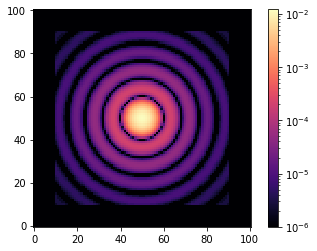

In [4]:
x = make_airy(10)

## Airy PSF

The intensity of the Airy pattern follows the Fraunhofer diffraction pattern of a circular aperture, given by the squared modulus of the Fourier transform of the circular aperture:

$$I(\theta) = I_0 \left[\frac{2J_1(ka\sin\theta)}{ka\sin\theta}\right]^2$$

where $I_0$ is the maximum intensity of the pattern at the Airy disc center, $J_1$ is the Bessel function of the first kind of order one, $k = 2 \pi/\lambda$ is the wavenumber, $a$ is the radius of the aperture, and $\theta$  is the angle of observation, *i.e.* the angle between the axis of the circular aperture and the line between aperture center and observation point.

In [5]:
def airy_intensity(max_intensity, aperture_size, wavelength, obs_angle):
    """Airy PSF
    
    Parameters
    ----------
    max_intensity: float
        Maximum intensity
    aperture_size: float
        Diameter of the aperature of the optical system in nanometres (nm)
    wavelength: float
        Wavelength of the light in nanometres (nm)
    obs_angle: float
        Angle of observation in degrees (deg)
    
    Returns
    -------
    float
        Airy intensity 
    
    """
    
    # Convert angle to radians
    obs_angle = obs_angle * np.pi / 180.0
    # 
    x = (2.0 * np.pi * aperture_size / wavelength) * np.sin(obs_angle)
    
    if isinstance(x, float) and x == 0.0:
        return 1.0
    elif isinstance(x, np.ndarray) and np.any(x == 1.0):
        np.ones(x.size)
    else:
        return max_intensity * (2.0 * jv(1, x) / x ) ** 2 

In [6]:
@interact(aperture_size=(1000, 5000, 1000), wavelength=(300, 900, 100))
def airy_pattern_1d(aperture_size, wavelength):
    
    angles = np.linspace(-90, 90, 1000)
    intensities = np.array(list(map(lambda angle: airy_intensity(1.0, aperture_size, wavelength, angle), angles)))
    
    plt.plot(angles, intensities)
    plt.title('Airy Pattern in 1D', fontsize=20)
    plt.xlabel(r'$\theta$', fontsize=18)
    plt.ylabel(r'I$(\theta)$', fontsize=18)
    plt.show()

interactive(children=(IntSlider(value=3000, description='aperture_size', max=5000, min=1000, step=1000), IntSl…

In [7]:
@interact(aperture_size=(1000, 5000, 1000), wavelength=(300, 900, 100), normalisation=['Log', 'None'])
def airy_pattern_2d(aperture_size, wavelength, normalisation='Log'):
    
    def angle_grid(n_points):
        # make sure n is odd
        spacing = np.linspace(-63.6, 63.63, n_points)
        x, y = np.meshgrid(spacing, spacing)

        return np.sqrt(x ** 2 + y ** 2)
    
    image_size = 101
    angles = angle_grid(image_size)
            
    disk = airy_intensity(1.0, aperture_size, wavelength, angles)
    
    if normalisation == 'Log':
        norm = colors.LogNorm()
    else:
        norm = None
    cmap = 'magma'
    
    plt.imshow(disk, interpolation='none', norm=norm, cmap=cmap, origin='lower')
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=3000, description='aperture_size', max=5000, min=1000, step=1000), IntSl…

https://www.sciencedirect.com/topics/engineering/airy-disk